In [69]:
import random

In [70]:
class Auction:
  def __init__(self, players, verbose=False):
    # immutable shuffle
    self.players = random.sample(
      players, 
      k=len(players)
    )
    self.history = []
    self.current_bid = 0
    self.winner = None

  def run(self):
    auction_finished = False
    abstain_count = 0

    while not auction_finished:
      player_count = len(self.players)

      for player in self.players:
        if abstain_count >= player_count - 1:
          auction_finished = True
          continue

        bid = player.play(self)
        
        if bid is None or bid > player.balance or bid <= self.current_bid:
          abstain_count += 1
          self.history.append((player, None))
          continue
        else:
          abstain_count = 0
          player.balance -= bid
          self.current_bid = bid
          self.history.append((player, bid))

    if(self.current_bid != 0):
      winner = self.history[-player_count][0]
      winner.balance += 100
      self.winner = winner

Let's create the an abstract class of player. This class will serve as the base for each player strategy we create. It shouldn't never be instanciated, only inherited.

In [71]:
class AbstractPlayer:
  def __init__(self, name, balance):
    self.name = name
    self.balance = balance

  def __str__(self):
    return f"{self.name}"

  def bid(self, amount):
    return amount

  def abstrain(self):
    return None

  # different stategies
  def play(self, auction: Auction):
    pass

Let's create a random player, which will bid based on a fair coin flip (50% bid, 50% abstain).

In [72]:
import random

class RandomPlayer(AbstractPlayer):
  def __init__(self, name, balance, increment):
    AbstractPlayer.__init__(self, name, balance)
    self.increment = increment

  def play(self, auction: Auction):
    player_bids = random.choice([True, False])

    if player_bids:
      return self.bid(auction.current_bid + self.increment)

    return self.abstrain()

Let's create a ceiling player, that will bid until it reaches a certain ceiling and abstain afterwords.

In [73]:
class CeilingPlayer(AbstractPlayer):
  def __init__(self, name, balance, ceiling, increment):
    AbstractPlayer.__init__(self, name, balance)
    self.ceiling = ceiling
    self.increment = increment

  def play(self, auction: Auction):
    # if auction.history == []:
    #   return self.bid(1)

    if auction.current_bid < self.ceiling:
      return self.bid(auction.current_bid + self.increment);

    return self.abstrain()

Let's run an auction with 2 participants, both using the `CeilingPlayer` strategy

In [74]:
p1 = CeilingPlayer("Alice", balance=1000, ceiling=100, increment=10)
p2 = CeilingPlayer("Bob", balance=1000, ceiling=100, increment=10)

players = [p1, p2]

auction = Auction(players=players)
auction.run()

In [75]:
p1_actions = filter(lambda action: action[0] == p1, auction.history)
p2_actions = filter(lambda action: action[0] == p2, auction.history)

for player, bid in auction.history:
  if bid is None:
    print(f"{player} abstained")
  else:
    print(f"{player} bids {bid}")

Alice bids 10
Bob bids 20
Alice bids 30
Bob bids 40
Alice bids 50
Bob bids 60
Alice bids 70
Bob bids 80
Alice bids 90
Bob bids 100
Alice abstained


In [76]:
print(f"Winner: {auction.winner}")

for player in players:
  print(f"{player}'s remaining balance: {player.balance}")

Winner: Bob
Alice's remaining balance: 750
Bob's remaining balance: 800


We've now seen how a single auction works. But the game itself is defined by a series of auctions (rounds), where each player's balance carries over from one auction to the other. The player that has the highest balance at the end of the repeated game is declared the winner. 

In [77]:
import numpy as np
import matplotlib.pyplot as plt

In [78]:
class RepeatedAuction:
  def __init__(self, players, rounds):
    self.players = players
    self.rounds = rounds
    self.data = np.zeros((len(players), rounds))

  def run(self):
    for round_index in range(self.rounds):
      auction = Auction(self.players)
      auction.run()
      for player_index, player in enumerate(self.players):
        self.data[player_index][round_index] = player.balance

  def plot(self):
    for player_index, player in enumerate(self.players):
      plt.plot(np.linspace(0, self.rounds, self.rounds), self.data[player_index], label=str(player))
    plt.xlabel('Game #')
    plt.ylabel('Player\'s Balance')
    plt.legend()
    plt.show()

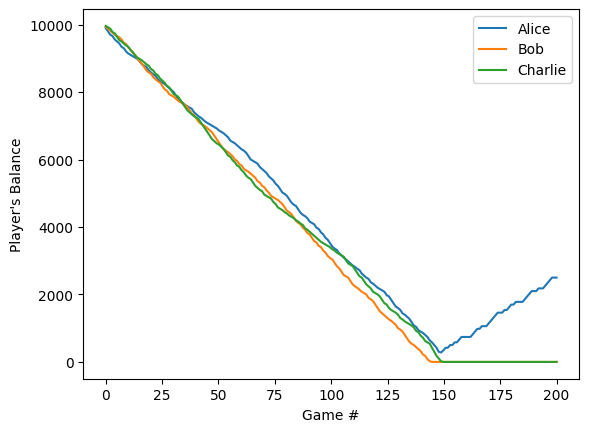

In [79]:
players = [
  CeilingPlayer("Alice",   balance=10000, ceiling=100, increment=20),
  CeilingPlayer("Bob",     balance=10000, ceiling=100, increment=20),
  CeilingPlayer("Charlie", balance=10000, ceiling=100, increment=20),
]

repeated_auction = RepeatedAuction(players, rounds=200)
repeated_auction.run()
repeated_auction.plot()

From the graph we can see that with each round players lose money, until all except one lose all of their votes (balance=0). After that the remaining player start to win money back from the auctioneer.

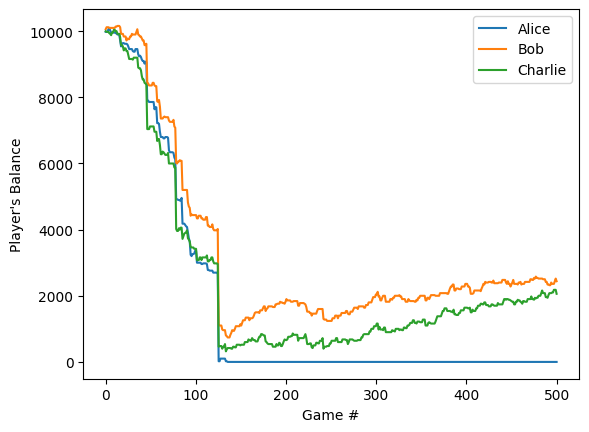

In [80]:
players = [
  RandomPlayer("Alice",   balance=10000, increment=20),
  RandomPlayer("Bob",     balance=10000, increment=20),
  RandomPlayer("Charlie", balance=10000, increment=20),
]

repeated_auction = RepeatedAuction(players, rounds=500)
repeated_auction.run()
repeated_auction.plot()

In [81]:
repeated_auction.data

array([[ 9980.,  9980.,  9980., ...,     0.,     0.,     0.],
       [10060., 10120., 10120., ...,  2440.,  2520.,  2440.],
       [10000.,  9980.,  9980., ...,  2180.,  2180.,  2060.]])

Now let's run the repeated auction a bunch of times and take averages for each player.

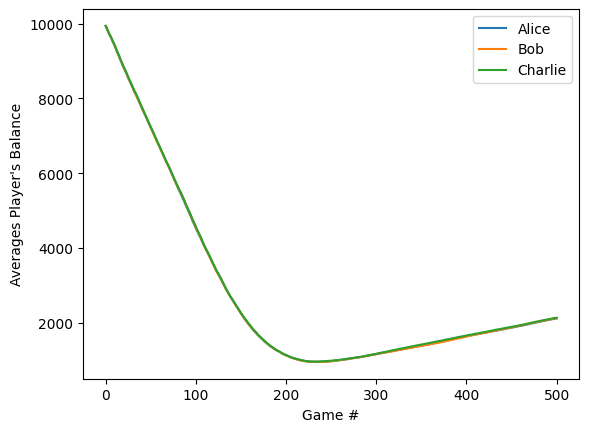

In [82]:
SIMULATIONS = 1000
ROUNDS = 500

data = np.zeros((SIMULATIONS, len(players), ROUNDS))

for i in range(SIMULATIONS):
  players = [
    RandomPlayer("Alice",   balance=10000, increment=20),
    RandomPlayer("Bob",     balance=10000, increment=20),
    RandomPlayer("Charlie", balance=10000, increment=20),
  ]

  repeated_auction = RepeatedAuction(players, rounds=ROUNDS)
  repeated_auction.run()

  data[i] = repeated_auction.data

averages = np.zeros((len(players), ROUNDS))

for i, player in enumerate(players):
  averages[i] = data[:,i,:].mean(axis=0)
  plt.plot(np.linspace(0, ROUNDS, ROUNDS), averages[i], label=str(player))

plt.xlabel('Game #')
plt.ylabel('Averages Player\'s Balance')
plt.legend() 
plt.show()


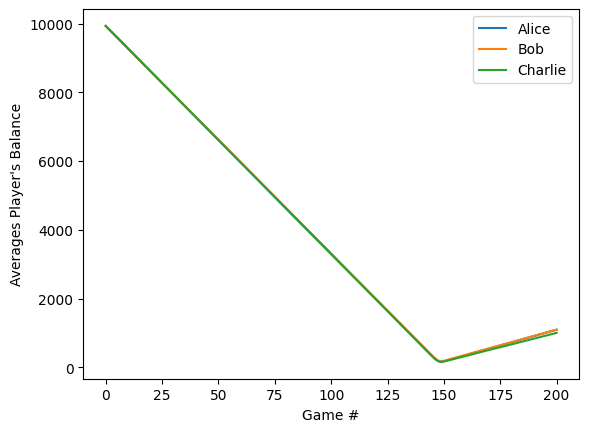

In [83]:
SIMULATIONS = 1000
ROUNDS = 200

data = np.zeros((SIMULATIONS, len(players), ROUNDS))

for i in range(SIMULATIONS):
  players = [
    CeilingPlayer("Alice",   balance=10000, ceiling=100, increment=20),
    CeilingPlayer("Bob",     balance=10000, ceiling=100, increment=20),
    CeilingPlayer("Charlie", balance=10000, ceiling=100, increment=20),
  ]

  repeated_auction = RepeatedAuction(players, rounds=ROUNDS)
  repeated_auction.run()

  data[i] = repeated_auction.data

averages = np.zeros((len(players), ROUNDS))

for i, player in enumerate(players):
  averages[i] = data[:,i,:].mean(axis=0)
  plt.plot(np.linspace(0, ROUNDS, ROUNDS), averages[i], label=str(player))

plt.xlabel('Game #')
plt.ylabel('Averages Player\'s Balance')
plt.legend() 
plt.show()

Now we can analyze player's with different strategies and advantages

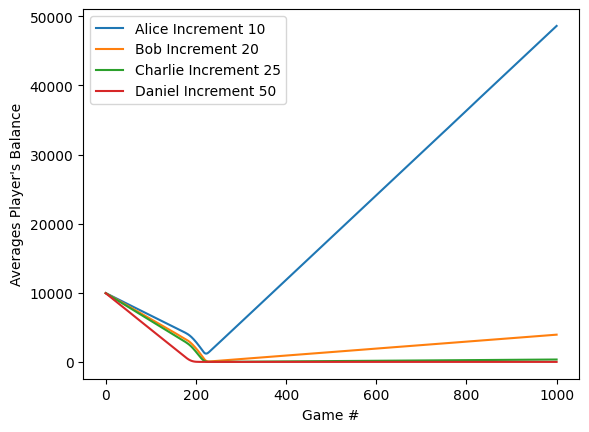

In [84]:
SIMULATIONS = 1000
ROUNDS = 1000

data = np.zeros((SIMULATIONS, 4, ROUNDS))

for i in range(SIMULATIONS):
  players = [
    CeilingPlayer("Alice Increment 10",   balance=10000, ceiling=100, increment=10),
    CeilingPlayer("Bob Increment 20",     balance=10000, ceiling=100, increment=20),
    CeilingPlayer("Charlie Increment 25", balance=10000, ceiling=100, increment=25),
    CeilingPlayer("Daniel Increment 50",  balance=10000, ceiling=100, increment=50),
  ]

  repeated_auction = RepeatedAuction(players, rounds=ROUNDS)
  repeated_auction.run()

  data[i] = repeated_auction.data

averages = np.zeros((len(players), ROUNDS))

for i, player in enumerate(players):
  averages[i] = data[:,i,:].mean(axis=0)
  plt.plot(np.linspace(0, ROUNDS, ROUNDS), averages[i], label=str(player))

plt.xlabel('Game #')
plt.ylabel('Averages Player\'s Balance')
plt.legend() 
plt.show()

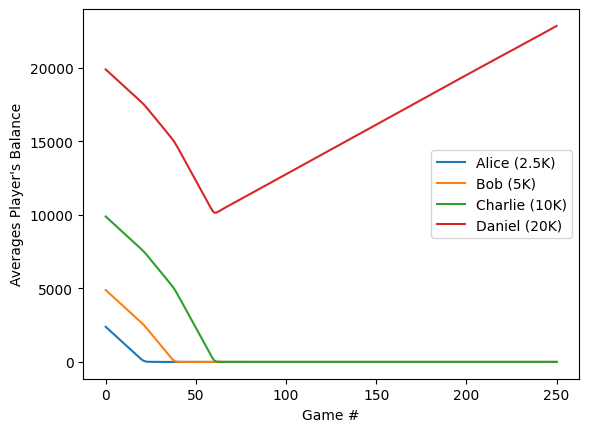

In [85]:
SIMULATIONS = 1000
ROUNDS = 250

data = np.zeros((SIMULATIONS, 4, ROUNDS))

for i in range(SIMULATIONS):
  players = [
    CeilingPlayer("Alice (2.5K)",  balance=2500, ceiling=100, increment=10),
    CeilingPlayer("Bob (5K)",      balance=5000, ceiling=100, increment=10),
    CeilingPlayer("Charlie (10K)", balance=10000, ceiling=100, increment=10),
    CeilingPlayer("Daniel (20K)",  balance=20000, ceiling=100, increment=10),
  ]

  repeated_auction = RepeatedAuction(players, rounds=ROUNDS)
  repeated_auction.run()

  data[i] = repeated_auction.data

averages = np.zeros((len(players), ROUNDS))

for i, player in enumerate(players):
  averages[i] = data[:,i,:].mean(axis=0)
  plt.plot(np.linspace(0, ROUNDS, ROUNDS), averages[i], label=str(player))

plt.xlabel('Game #')
plt.ylabel('Averages Player\'s Balance')
plt.legend() 
plt.show()

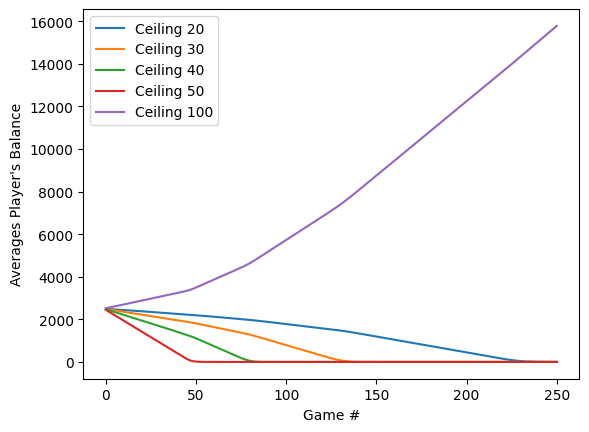

In [86]:
SIMULATIONS = 1000
ROUNDS = 250

data = np.zeros((SIMULATIONS, 5, ROUNDS))

for i in range(SIMULATIONS):
  players = [
    CeilingPlayer("Ceiling 20",  balance=2500, ceiling=20, increment=10),
    CeilingPlayer("Ceiling 30" , balance=2500, ceiling=30, increment=10),
    CeilingPlayer("Ceiling 40" , balance=2500, ceiling=40, increment=10),
    CeilingPlayer("Ceiling 50",  balance=2500, ceiling=50, increment=10),
    CeilingPlayer("Ceiling 100", balance=2500, ceiling=100, increment=10),
  ]

  repeated_auction = RepeatedAuction(players, rounds=ROUNDS)
  repeated_auction.run()

  data[i] = repeated_auction.data

averages = np.zeros((len(players), ROUNDS))

for i, player in enumerate(players):
  averages[i] = data[:,i,:].mean(axis=0)
  plt.plot(np.linspace(0, ROUNDS, ROUNDS), averages[i], label=str(player))

plt.xlabel('Game #')
plt.ylabel('Averages Player\'s Balance')
plt.legend() 
plt.show()

In [100]:
price_vector = np.arange(1, 101)

In [101]:
class AbstractPlayer:
  def __init__(self, id, strategy, balance):
    self.id = id
    self.strategy_vector = strategy
    self.balance = balance

In [96]:
class HundredVoteAuction:
  history = []
  players = []
  
  bid_index = 0
  bid_price = 1
  bid_holder = None
  
  def __init__(self, players):
    self.players = players

  def run(self):
    for player in players:
      bid_index = self.bid_index

      player_abstains = sum(player.strategy[bid_index:]) == 0

      if player_abstains:
        self.history.append((player, None))
      else:
        next_bid_index = np.argmax(player.strategy[bid_index:]) + bid_index
        next_bid = price_vector[next_bid_index]

        self.bid_index = next_bid_index
        self.bid_price = next_bid
        self.bid_holder = player

        player.balance -= next_bid

In [102]:
yumeko = np.zeros(100)
yumeko[0] = 1
yumeko[-1] = 1

generic = np.zeros(100)
generic[:50:10] = 1

generic * price_vector, yumeko * price_vector

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 11.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., 21.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., 31.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., 41.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [106]:
auction = HundredVoteAuction([
  AbstractPlayer(1, generic, 100),
  AbstractPlayer(2, yumeko, 100),
])

auction.run()

AttributeError: 'CeilingPlayer' object has no attribute 'strategy'